# Infer ***peroxisomes*** - part 7️⃣

--------------

## OBJECTIVE:  ✅ Infer sub-cellular component ***peroxisomes*** in order to understand interactome 



Dependencies:
The ***peroxisomes***  inference rely on the cytosol mask.



## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict

import numpy as np
import scipy

# TODO:  prune the imports.. this is the big set for almost all organelles
# # function for core algorithm
from scipy import ndimage as ndi
import aicssegmentation
from aicssegmentation.core.seg_dot import dot_3d_wrapper, dot_slice_by_slice, dot_2d_slice_by_slice_wrapper, dot_3d
from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_3d,  
                                                         image_smoothing_gaussian_slice_by_slice )
from aicssegmentation.core.utils import topology_preserving_thinning, size_filter
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.vessel import filament_2d_wrapper, vesselnessSliceBySlice
from aicssegmentation.core.output_utils import   save_segmentation,  generate_segmentation_contour
                                                 
from skimage import filters
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects, binary_closing, ball , dilation, remove_small_holes   # function for post-processing (size filter)
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc_2d.utils.file_io import (read_czi_image, 
                                                                    list_image_files, 
                                                                    export_ome_tiff, 
                                                                    etree_to_dict, 
                                                                    save_parameters, 
                                                                    load_parameters, 
                                                                    export_ndarray)
from infer_subc_2d.utils.img import *
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH )        
from infer_subc_2d.organelles.soma import infer_soma
from infer_subc_2d.organelles.nuclei import infer_nuclei
from infer_subc_2d.organelles.cytosol import infer_cytosol

%load_ext autoreload
%autoreload 2

test_img_n = 5

# IMAGE PROCESSING Objective 7:  infer ***peroxisomes***
> Back to  [OUTLINE: Objective #5](00_pipeline_setup.ipynb#summary-of-objectives)


## summary & steps

Generally following the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.

> PMP34 os  good start for Peroxisomes  as per from [Allen Cell](https://www.allencell.org/cell-observations/category/peroxisome)

> [playground_dots.ipynb](https://github.com/AllenInstitute/aics-segmentation/blob/master/lookup_table_demo/playground_dots.ipynb)

### steps

INPUT
- ch 4
- cytosol mask

PRE-PROCESSING
-  MM scale
-  G2 gaussian filter 2D 
   -  sigma = 1.

CORE-PROCESSING
- S2 - dot filter
- W - watershed to disambiguate overlapping dots

POST-PROCESSING
  - S  - remove dots less than 2x2 pixels (area = 4)

OUTPUT
- object ***peroxisomes*** 





>#### ASIDE:  3D Spot filter (S3)
>* Parameter syntax: `[[scale_1, cutoff_1], [scale_2, cutoff_2], ....]` 
>    * `scale_x` is set based on the estimated radius of your target dots. For example, if visually the diameter of the dots is usually 3~4 pixels, then you may want to set `scale_x` as `1` or something near `1` (like `1.25`). Multiple scales can be used, if you have dots of very different sizes.  
>    * `cutoff_x` is a threshold applied on the actual filter reponse to get the binary result. Smaller `cutoff_x` may yielf more dots and fatter segmentation, while larger `cutoff_x` could be less permisive and yield less dots and slimmer segmentation. 
>* Parameter for PMP34:  `s3_param = [[1,0.03]]`



------------------------
# LOAD RAW IMAGE DATA
Identify path to _raw_ image data and load our example image


In [2]:
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]

img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## CHOOZE Z-SLICE

Lets find the slice with the most overall intensity...

In [3]:
ch_to_agg = ( LYSO_CH ,
                        MITO_CH ,
                        GOLGI_CH ,
                        PEROXI_CH ,
                        ER_CH ,
                        LIPID_CH )
                            
nuc_ch = NUC_CH
optimal_Z = find_optimal_Z(img_data, nuc_ch, ch_to_agg) 



Now get the single "optimal" slice of all our organelle channels....

In [4]:
img_2D = img_data[:,[optimal_Z],:,:].copy()

## Collect the ***cytosol*** mask

i.e. inferred soma, nuclei and cytosol objects
(takes < 1 sec)

In [5]:

soma_mask =  infer_soma(img_2D) 
nuclei_object =  infer_nuclei(img_2D, soma_mask) 
cytosol_mask =  infer_cytosol( nuclei_object,soma_mask) 


## Build  ***Peroxisome***  specific inference workflow



### INPUT

In [6]:
###################
# INPUT
###################
raw_peroxi   = img_2D[PEROXI_CH].copy()


### PRE-PROCESSING

In [7]:
###################
# PRE_PROCESSING
###################
struct_img = min_max_intensity_normalization( raw_peroxi )

gaussian_smoothing_sigma = 1.34
gaussian_smoothing_truncate_range = 3.0

structure_img_smooth = image_smoothing_gaussian_slice_by_slice(   struct_img,
                                                                                                                        sigma=gaussian_smoothing_sigma,
                                                                                                                        truncate_range=gaussian_smoothing_truncate_range,
                                                                                                                    )


### CORE PROCESSING

In [8]:
###################
# CORE_PROCESSING
###################

################################
## PARAMETERS for this step ##
s2_param = [[1, 0.03]]
################################
bw = dot_2d_slice_by_slice_wrapper(structure_img_smooth, s2_param)

### POST-PROCESSING

> NOTE:  AllenCell Segmenter suggests using a masked watershed to disambiguate overlapping peroxisomes, but it is depricated here as our contrast/separation is pretty good.

In [9]:

###################
# POST_PROCESSING
###################
# watershed
#minArea = 4
# mask_ = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False) 
# seed_ = dilation(peak_local_max(struct_img,labels=label(mask_), min_distance=2, indices=False), selem=ball(1))
# watershed_map = -1*ndi.distance_transform_edt(bw)
# struct_obj = watershed(watershed_map, label(seed_), mask=mask_, watershed_line=True)


bw = apply_mask(bw, cytosol_mask)

################################
## PARAMETERS for this step ##
small_object_width = 2 
################################

#struct_obj = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)
peroxi_object = size_filter_2D(bw, 
                                                min_size= small_object_width**2, 
                                                connectivity=1)

#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [10]:
viewer = napari.Viewer()


viewer = napari.view_image(
    peroxi_object,
    scale=scale
)

viewer.scale_bar.visible = True
viewer.add_image(
    structure_img_smooth,
    scale=scale
)


<Image layer 'structure_img_smooth' at 0x14ba398b0>

### Collect into a single `infer_peroxisome` function

In [11]:
##########################
#  infer_peroxisome
##########################
def _infer_peroxisome(in_img:  np.ndarray, cytosol_mask:  np.ndarray) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input.

    Parameters:
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels

    cytosol_mask: np.ndarray
        mask of cytosol
 
    Returns:
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """

    ###################
    # PRE_PROCESSING
    ###################                         
    struct_img = min_max_intensity_normalization(in_img[PEROXI_CH].copy() )

    gaussian_smoothing_sigma = 1.34
    gaussian_smoothing_truncate_range = 3.0
    struct_img = image_smoothing_gaussian_slice_by_slice(   struct_img,
                                                                                                        sigma=gaussian_smoothing_sigma,
                                                                                                        truncate_range = gaussian_smoothing_truncate_range
                                                                                                    )
   ###################
    # CORE_PROCESSING
    ###################
    dot_2d_sigma = 1.
    dot_2d_cutoff = 0.04
    s2_param = [(dot_2d_sigma,dot_2d_cutoff)]

    bw = dot_2d_slice_by_slice_wrapper(struct_img, s2_param)


    ###################
    # POST_PROCESSING
    ###################
    do_watershed = False
    if do_watershed: # BUG: this makes bw into labels... but we are returning a binary object...
        minArea = 4
        mask_ = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False) 
        seed_ = dilation(peak_local_max(struct_img,labels=label(mask_), min_distance=2, indices=False), selem=ball(1))
        watershed_map = -1*ndi.distance_transform_edt(bw)
        bw = watershed(watershed_map, label(seed_), mask=mask_, watershed_line=True)
   

    ###################
    # POST_PROCESSING
    ###################
    struct_obj = apply_mask(bw, cytosol_mask)

    small_object_width = 2
    struct_obj = size_filter_2D(struct_obj, 
                                                min_size= small_object_width**2, 
                                                connectivity=1)


    return struct_obj

# TEST  `_infer_peroxisome` function

In [14]:
_peroxi_object =  _infer_peroxisome(img_2D, cytosol_mask) 


In [12]:
from infer_subc_2d.organelles.peroxisomes import infer_peroxisome 

peroxi_object =  infer_peroxisome(img_2D, cytosol_mask) 


In [15]:

viewer.add_image(
    peroxi_object,
    scale=scale
)

viewer.add_image(
    _peroxi_object,
    scale=scale
)

viewer.add_labels(
    label(peroxi_object),
    scale=scale
)

<Labels layer 'Labels' at 0x188be7b50>

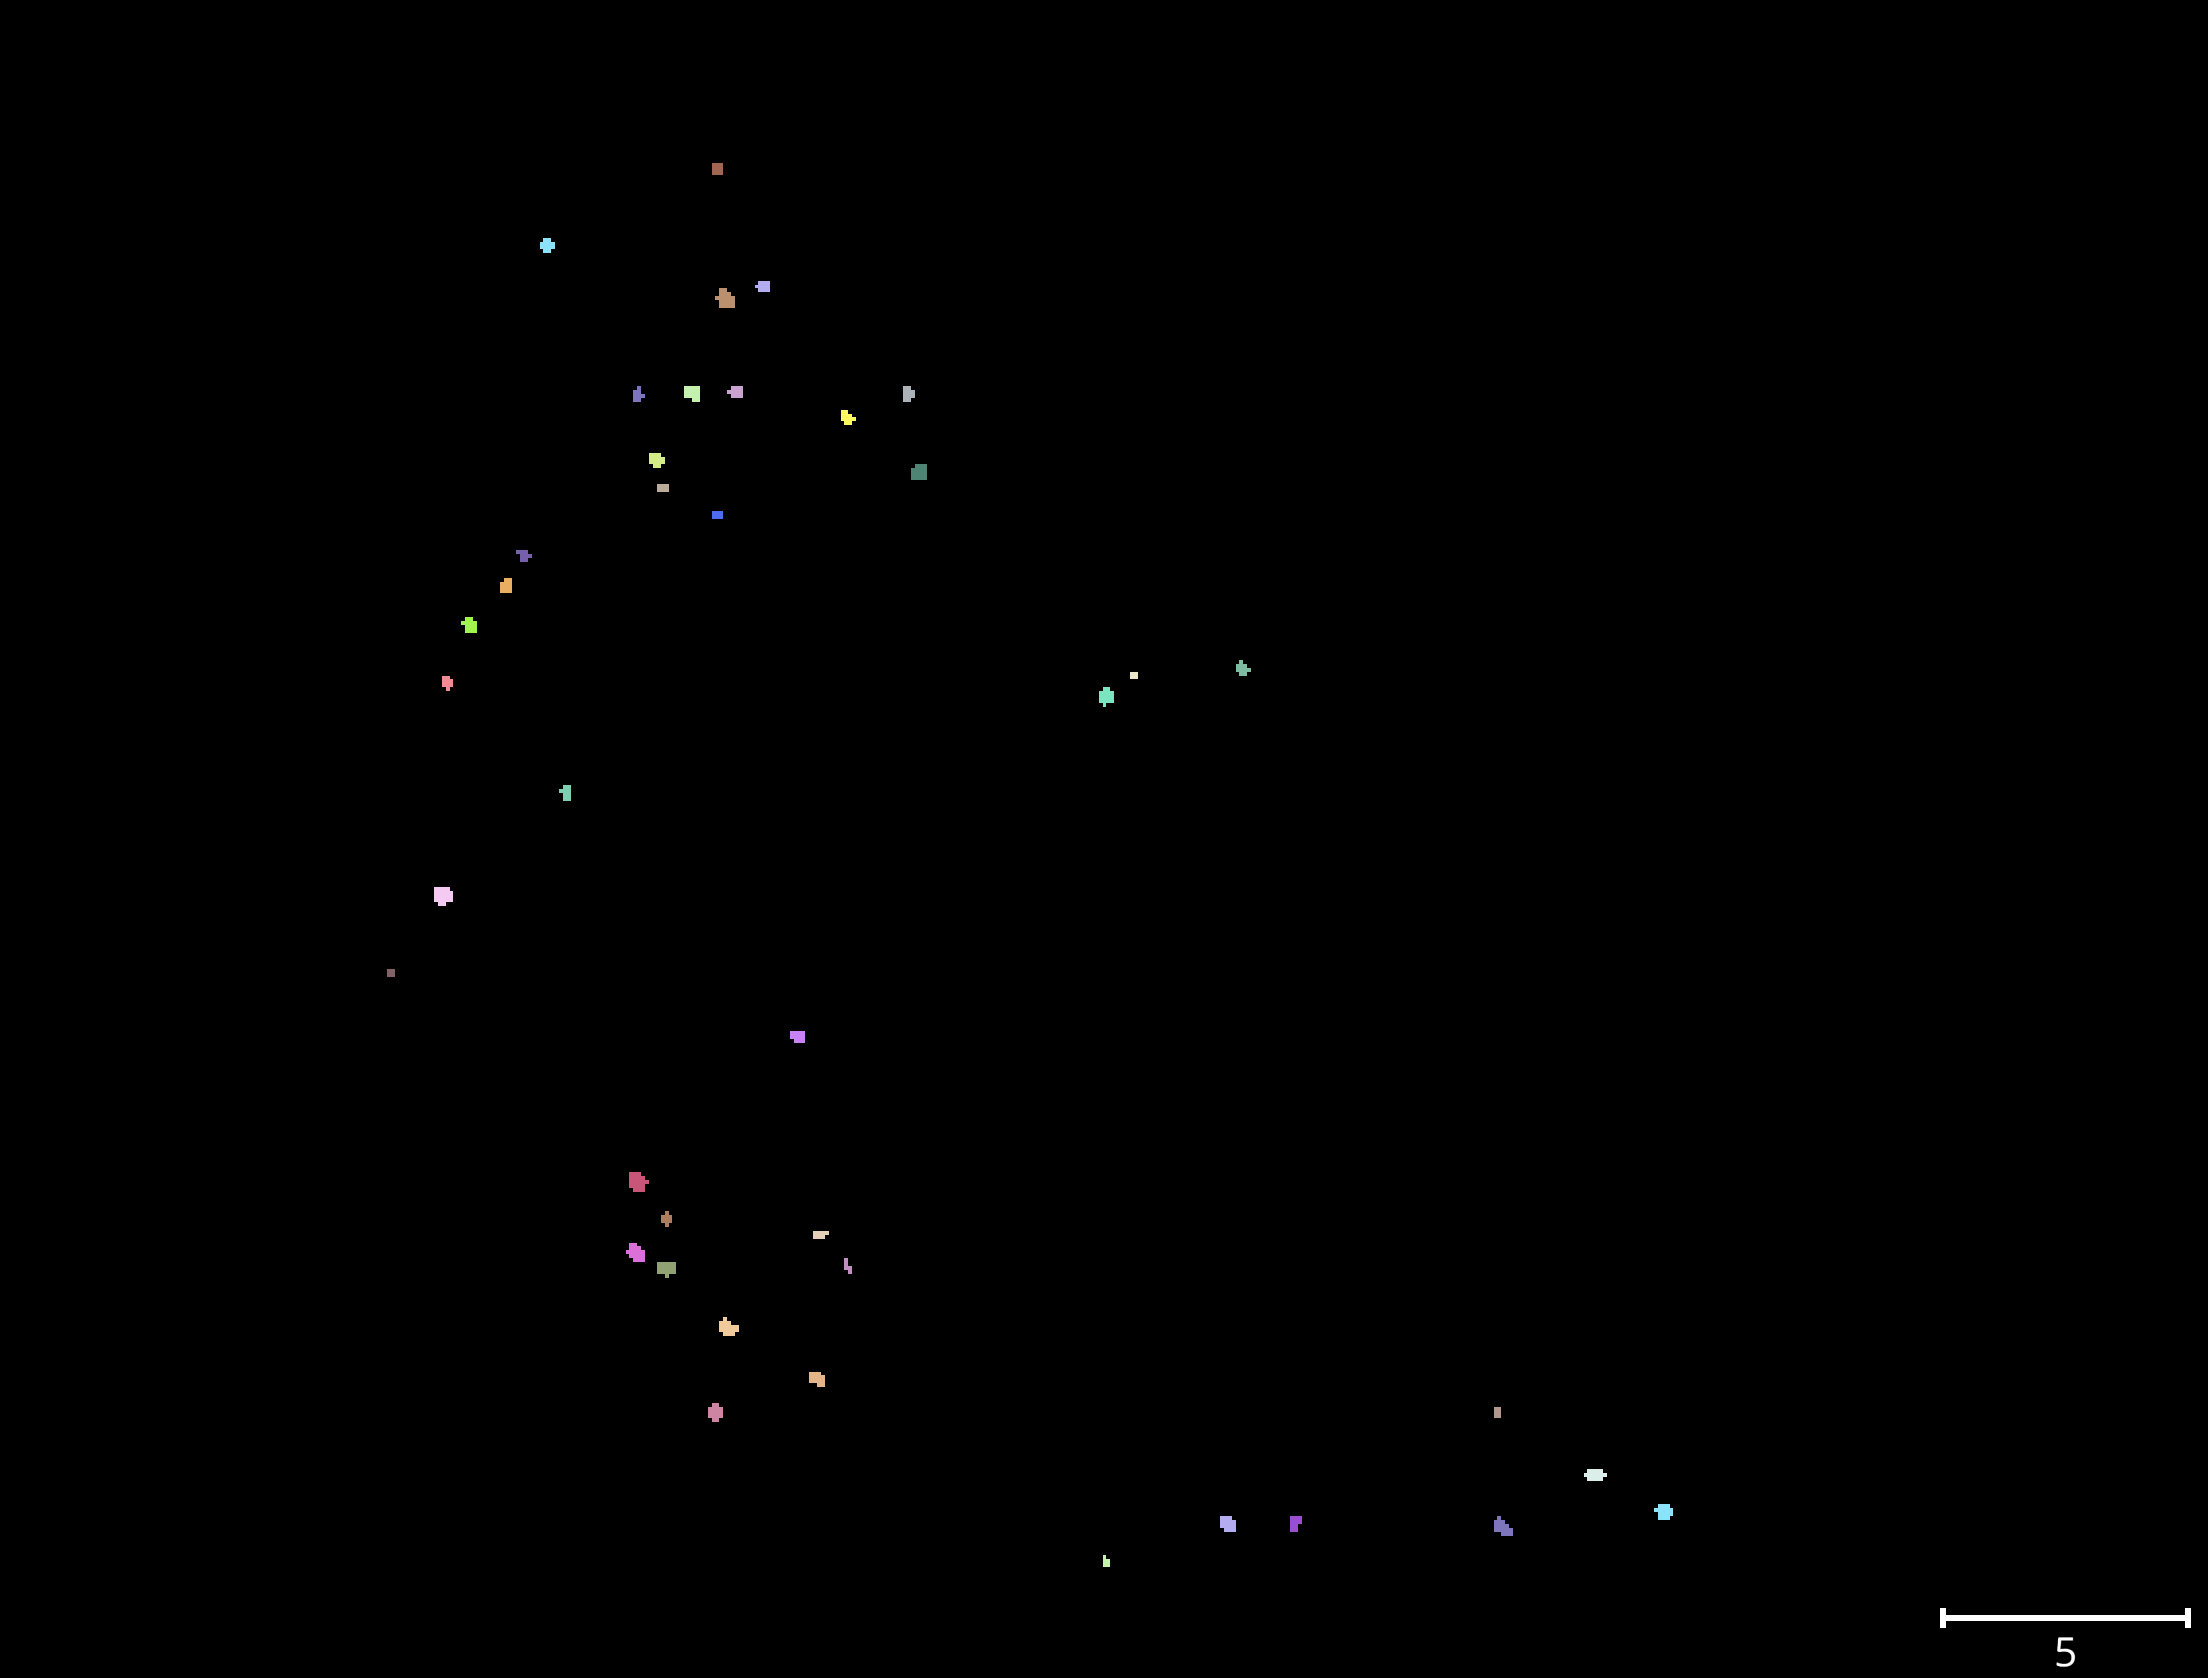

In [16]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

---------------------

 🚧 WIP 🚧 (🚨🚨🚨🚨 )


# WORKFLOW #2 (WIP)
as per 6/22 CellProfiler pipeline from MCZ
 
## summary of steps

INPUT
- ch 4
- CY mask

PRE-PROCESSING
-   non-local noise reduction
  - size:4, distance:2, cut-off:0.08

CORE-PROCESSING
- adaptive Otsu
    - diameter: (4,100)
  - two classes
    - threshold smoothing scale: 1.34
    - threshold correction factor: .75
    - threshold bounds: (0.14, 1)
    - adaptive window: 20 pixels

- POST-PROCESSING
  - N/A

OUTPUT
- object PEROXISOME

### INPUT

### PRE-PROCESSING

In [ ]:
###################
# PRE_PROCESSING
###################

intensity_norm_param = [0] # 

# Linear-ish smoothing
raw_mito = intensity_normalization( struct_img_raw ,  scaling_param=intensity_norm_param)

med_filter_size =3  

gaussian_smoothing_sigma = 1.3
gaussian_smoothing_truncate_range = 3.0

struct_img = median_filter(raw_mito,    size=med_filter_size  )

structure_img_smooth = image_smoothing_gaussian_slice_by_slice(   struct_img,
                                                                                                                        sigma=gaussian_smoothing_sigma,
                                                                                                                        truncate_range=gaussian_smoothing_truncate_range,
                                                                                                                    )


# log_img, d = log_transform( structure_img_smooth ) 
# struct_img = intensity_normalization(  log_img  ,  scaling_param=[0] )  

struct_img = structure_img_smooth

### CORE PROCESSING

In [ ]:
###################
# CORE_PROCESSING
###################
def _enhance_speckles(image, radius, volumetric=True):
    radius = radius / 2
    if volumetric:
        selem = ball(radius)
    else:
        selem = disk(radius)     

    # if radius >10:
    #         minimum = scipy.ndimage.minimum_filter(image, footprint=selem)
    #         maximum = scipy.ndimage.maximum_filter(minimum, footprint=selem)
    #         result = data - maximum
    # else:
    result =  white_tophat(image)

    return result

def enhance_neurites(image, radius, volumetric = True):
    if volumetric:
        selem = ball(radius)
    else:
        selem = disk(radius)     
    white = white_tophat(image,selem)
    black = black_tophat(image, selem)
    result = image + white - black
    result[result > 1] = 1
    result[result < 0] = 0

    return result

    



In [ ]:
# enhance spreckles - 40
big_struct_rad = 40
big_img = _enhance_speckles(struct_img.copy(),big_struct_rad, True)



In [ ]:

# enhance spreckles - 10
sm_struct_rad = 20
sm_img = _enhance_speckles(struct_img.copy(),sm_struct_rad, True)


#adaptive_otsu(big_struct) # three class - middle foreground
# adaptive window- 20
#size: 10,100
# threshold smooth 1.34
# threshold correction 1
# threshold (0.1497,1)
#fill holes
# "adatpive" thresholds are NOT currently working... will use      
# "Masked Object Thresholding" - 3D
low_level_min_size = 10
bw_big, _bw_low_level = MO(big_img, 
                                                global_thresh_method='ave', 
                                                object_minArea=low_level_min_size, 
                                                extra_criteria=True,
                                                local_adjust= 0.5, 
                                                return_object=True,
                                                dilate=True)
 # or this?                                               
#    struct_obj = struct_img > filters.threshold_otsu(struct_img)
#     threshold_value_log = threshold_otsu_log(struct_img)

#     threshold_factor = 0.9 #from cellProfiler
#     thresh_min = .1
#     thresh_max = 1.
#     threshold = min( max(threshold_value_log*threshold_factor, thresh_min), thresh_max)
#     struct_obj = struct_img > threshold


# enhance speckles
#   adaptive_sauvola(sm_struct) 
# adaptive window- 10
#size: 2,10
# threshold smooth 1.34
# threshold correction 1
# threshold (0.05,1)
#fill holes
# "adatpive" thresholds are NOT currently working... will use      
# "Masked Object Thresholding" - 3D
low_level_min_size = 2
bw_sm, _bw_low_level = MO(sm_img, 
                                                global_thresh_method='ave', 
                                                object_minArea=low_level_min_size, 
                                                extra_criteria=True,
                                                local_adjust= 0.5, 
                                                return_object=True,
                                                dilate=True)
 # or this?                                               
#    struct_obj = struct_img > filters.threshold_otsu(struct_img)
#     threshold_value_log = threshold_otsu_log(struct_img)
#     threshold_factor = 0.9 #from cellProfiler
#     thresh_min = .1
#     thresh_max = 1.
#     threshold = min( max(threshold_value_log*threshold_factor, thresh_min), thresh_max)
#     struct_obj = struct_img > threshold



### POST-PROCESSING

In [ ]:
###################
# POST_PROCESSING
###################


# 3D
# cleaned_img = remove_small_objects(removed_holes>0, 
#                                                             min_size=minArea, 
#                                                             connectivity=1, 
#                                                             in_place=False)
small_object_width = 10
cleaned_img_big = size_filter(bw_big, # wrapper to remove_small_objects which can do slice by slice
                                                         min_size= small_object_width**2,
                                                         method = "slice_by_slice",
                                                         connectivity=1)


#                                                             in_place=False)
small_object_width = 2
cleaned_img_sm = size_filter(bw_sm, # wrapper to remove_small_objects which can do slice by slice
                                                         min_size= small_object_width**2,
                                                         method = "slice_by_slice",
                                                         connectivity=1)



cleaned_img = np.logical_or(cleaned_img_big, cleaned_img_sm)



#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [ ]:

if viewer is None:
    viewer = napari.view_image(
        cleaned_img,
        scale=scale
    )
else: 
    viewer.add_image(
        cleaned_img,
        scale=scale
    )

viewer.scale_bar.visible = True
viewer.add_image(
    cleaned_img_big,
    scale=scale
)

viewer.add_image(
    big_img,
    scale=scale
)
viewer.add_image(
    cleaned_img_big,
    scale=scale
)
viewer.add_image(
    sm_img,
    scale=scale
)